In [1]:
import numpy as np
import numpy.random as nrand
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [2]:
def get_natural_cubic_spline_model(x, y, minval=None, maxval=None, n_knots=None, knots=None):
    """
    Get a natural cubic spline model for the data.

    For the knots, give (a) `knots` (as an array) or (b) minval, maxval and n_knots.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.

    Parameters
    ----------
    x: np.array of float
        The input data
    y: np.array of float
        The outpur data
    minval: float 
        Minimum of interval containing the knots.
    maxval: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.

    Returns
    --------
    model: a model object
        The returned model will have following method:
        - predict(x):
            x is a numpy array. This will return the predicted y-values.
    """

    if knots is not None:
        spline = NaturalCubicSpline(knots=knots)
    else:
        spline = NaturalCubicSpline(max=maxval, min=minval, n_knots=n_knots)

    p = Pipeline([
        ('nat_cubic', spline),
        ('regression', LinearRegression(fit_intercept=True))
    ])

    p.fit(x, y)

    return p


class AbstractSpline(BaseEstimator, TransformerMixin):
    """Base class for all spline basis expansions."""

    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None):
        if knots is None:
            if not n_knots:
                n_knots = self._compute_n_knots(n_params)
            knots = np.linspace(min, max, num=(n_knots + 2))[1:-1]
            max, min = np.max(knots), np.min(knots)
        self.knots = np.asarray(knots)

    @property
    def n_knots(self):
        return len(self.knots)

    def fit(self, *args, **kwargs):
        return self


class NaturalCubicSpline(AbstractSpline):
    """Apply a natural cubic basis expansion to an array.
    The features created with this basis expansion can be used to fit a
    piecewise cubic function under the constraint that the fitted curve is
    linear *outside* the range of the knots..  The fitted curve is continuously
    differentiable to the second order at all of the knots.
    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.  

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.
    Parameters
    ----------
    min: float 
        Minimum of interval containing the knots.
    max: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.
    """

    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = X.squeeze()
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError: # For arrays with only one element
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X.squeeze()

        def d(knot_idx, x):
            def ppart(t): return np.maximum(0, t)

            def cube(t): return t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                         - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X)).squeeze()
        return X_spl

In [3]:
# set global lists for looping
model_list = ['NK','RMF','Polynomial']
metric_list = ['N_max','epi','r_s','open_ratio','E','gamma','adptwalk_steps','adptwalk_probs']
N_list = [5,10,15]
error_list = [0.02,0.04,0.06,0.08]

In [4]:
# Load plot data
plot_dict = {N: {model: {metric: {} for metric in metric_list} for model in model_list} for N in N_list}
for N in N_list:
    for model in model_list:
        for metric in metric_list:
            with open(f'plot_data/plot_df_{model}_{N}_{metric}.pkl', 'rb') as f:
                plot_dict[N][model][metric] = pickle.load(f)

In [5]:
# plot settings:
# keys of the dictionary represents N (number of variable sites), FL model, and ruggedness measures
# j, sd: parameter for curve smoothing; lim: scale limit of x-axis and y-axis
# labelpad: the space between y-label and the body of plot

para_dict = {
    5:{
        'NK':{
            'N_max':{'j':[1,8],'sd':1,'lim':[0,10],'labelpad':15},#
            'epi':{'j':[0,12],'sd':0.02,'lim':[0,0.3],'labelpad':22},#
            'r_s':{'j':[0,6],'sd':0.8,'lim':[0,10],'labelpad':13},#
            'open_ratio':{'j':[0,16],'sd':0.008,'lim':[0,0.7],'labelpad':30}
        },
        'RMF':{
            'N_max':{'j':[1,8],'sd':1,'lim':[0,10],'labelpad':15},#
            'epi':{'j':[0,12],'sd':0.02,'lim':[0,0.3],'labelpad':22},#
            'r_s':{'j':[0,8],'sd':0.8,'lim':[0,10],'labelpad':13},#
            'open_ratio':{'j':[0,16],'sd':0.008,'lim':[0,0.7],'labelpad':30}
        },
        'Polynomial':{
            'N_max':{'j':[0,4],'sd':1,'lim':[0,10],'labelpad':15}, #
            'epi':{'j':[0,8],'sd':0.01,'lim':[0,0.3],'labelpad':22},#
            'r_s':{'j':[0,8],'sd':0.2,'lim':[0,4],'labelpad':13},#
            'open_ratio':{'j':[3,18],'sd':0.008,'lim':[0,0.7],'labelpad':30}
        }
    },
    10:{
        'NK':{
            'N_max':{'j':[0,20],'sd':5,'lim':[0,110],'labelpad':20}, #
            'epi':{'j':[0,12],'sd':0.02,'lim':[0,0.2],'labelpad':30},#
            'r_s':{'j':[0,10],'sd':2,'lim':[0,20],'labelpad':13},#
            'open_ratio':{'j':[0,16],'sd':0.008,'lim':[0,0.9],'labelpad':30},
            
            'E':{'j':[0,16],'sd':0.008,'lim':[0,1],'labelpad':30},
            'gamma':{'j':[0,16],'sd':0.008,'lim':[0,1],'labelpad':30},
            'adptwalk_steps':{'j':[0,16],'sd':0.008,'lim':[1.5,7],'labelpad':30},
            'adptwalk_probs':{'j':[0,16],'sd':0.008,'lim':[0,1],'labelpad':30}
        },
        'RMF':{
            'N_max':{'j':[0,20],'sd':5,'lim':[0,110],'labelpad':20}, #
            'epi':{'j':[0,12],'sd':0.02,'lim':[0,0.2],'labelpad':30},#
            'r_s':{'j':[0,10],'sd':2,'lim':[0,20],'labelpad':13},#
            'open_ratio':{'j':[0,16],'sd':0.008,'lim':[0,0.9],'labelpad':30},
            
            'E':{'j':[0,16],'sd':0.008,'lim':[0,1],'labelpad':30},
            'gamma':{'j':[0,16],'sd':0.008,'lim':[0,1],'labelpad':30},
            'adptwalk_steps':{'j':[0,16],'sd':0.008,'lim':[1.5,7],'labelpad':30},
            'adptwalk_probs':{'j':[0,16],'sd':0.008,'lim':[0,1],'labelpad':30}
        },
        'Polynomial':{
            'N_max':{'j':[1,10],'sd':1,'lim':[0,75],'labelpad':20},#
            'epi':{'j':[0,8],'sd':0.01,'lim':[0,0.15],'labelpad':30},#
            'r_s':{'j':[0,10],'sd':0.3,'lim':[0,4],'labelpad':13},#
            'open_ratio':{'j':[8,18],'sd':0.008,'lim':[0,0.9],'labelpad':30},
            
            'E':{'j':[0,16],'sd':0.008,'lim':[0,1],'labelpad':30},
            'gamma':{'j':[0,16],'sd':0.008,'lim':[0.2,1.1],'labelpad':30},
            'adptwalk_steps':{'j':[0,16],'sd':0.008,'lim':[1.5,7],'labelpad':30},
            'adptwalk_probs':{'j':[0,16],'sd':0.008,'lim':[0,1],'labelpad':30}
        },

    },
    15:{
        'NK':{
            'N_max':{'j':[-1,9],'sd':250,'lim':[0,2300],'labelpad':40},#
            'epi':{'j':[0,12],'sd':0.02,'lim':[0,0.2],'labelpad':35},#
            'r_s':{'j':[0,13],'sd':10,'lim':[0,150],'labelpad':25},#
            'open_ratio':{'j':[0,16],'sd':0.008,'lim':[0,0.9],'labelpad':30}
        },
        'RMF':{
            'N_max':{'j':[0,18],'sd':150,'lim':[0,2300],'labelpad':40},#
            'epi':{'j':[0,12],'sd':0.02,'lim':[0,0.2],'labelpad':35},#
            'r_s':{'j':[0,22],'sd':0.5,'lim':[0,15],'labelpad':13},#
            'open_ratio':{'j':[0,16],'sd':0.008,'lim':[0,0.9],'labelpad':30}
        },
        'Polynomial':{
            'N_max':{'j':[0,20],'sd':1,'lim':[0,1500],'labelpad':40},#
            'epi':{'j':[0,8],'sd':0.01,'lim':[0,0.2],'labelpad':35},#
            'r_s':{'j':[0,12],'sd':0.3,'lim':[0,5],'labelpad':13},#
            'open_ratio':{'j':[10,18],'sd':0.008,'lim':[0,0.9],'labelpad':30}
        }
    }
}

In [6]:
## Another way to smooth the curve
# def get_mean_df(plot_df,N,model,metric):
#     mean_dict = {f'{metric}_T':[],f'{metric}_E_mean':[],'std':[]}
#     sd = para_dict[N][model][metric]['sd']
#     for i in error_list:
#         plot_df_ = plot_df[plot_df['std']==i]
#         for j in range(*para_dict[N][model][metric]['j']):
#             mean_E = np.mean(plot_df_[(plot_df_[f'{metric}_T']<=(j+1)*sd) & (plot_df_[f'{metric}_T']>=j*sd)][f'{metric}_E'])
#             mean_dict[f'{metric}_T'].append((j+0.5)*sd)
#             mean_dict['std'].append(i)
#             mean_dict[f'{metric}_E_mean'].append(mean_E)
#     return pd.DataFrame(mean_dict) 

def get_mean_df(plot_df,N,model,metric):
    """
    apply cubic spline to smooth the curve.
    """
    mean_dict = {f'{metric}_T':[],f'{metric}_E_mean':[],'std':[]}
    for i in error_list:
        # prepare x and y
        x = plot_df[plot_df['std']==i][f'{metric}_T']
        sort_idx = np.argsort(x)
        x = np.array(x)[sort_idx]
        y = plot_df[plot_df['std']==i][f'{metric}_E']
        y = np.array(y)[sort_idx]
        
        # specify knots for cubic spline smoothing
        knots_ = np.percentile(x,q=[1,20,40,60,80]) 
        
        # Take 1st and 99th percentile as the x-axis range for smoothing
        left,right = np.percentile(x,q=[1,99]) 
        
        # Get cubic spline
        if metric == 'N_max' and model == 'Polynomial' and N == 5:
            spl = get_natural_cubic_spline_model(x, y, minval=min(x), maxval=max(x), n_knots=5)
        else:
            spl = get_natural_cubic_spline_model(x, y, minval=min(x), maxval=max(x), knots=knots_)
        
        # Generate dots to draw cubic spline
        xs = np.linspace(left, right,100)
        mean_E = spl.predict(xs)
        mean_dict[f'{metric}_T'].append(xs)
        mean_dict['std'].append([i]*100)
        mean_dict[f'{metric}_E_mean'].append(mean_E)

    mean_dict[f'{metric}_T'] = np.concatenate(mean_dict[f'{metric}_T'])
    mean_dict['std'] = np.concatenate(mean_dict['std'])
    mean_dict[f'{metric}_E_mean'] = np.concatenate(mean_dict[f'{metric}_E_mean'])
    return pd.DataFrame(mean_dict) 

In [7]:
def draw_by_metric(metric):
    """
    draw plots for a specific ruggedness measure
    """
    fig = plt.figure(figsize=(30, 30))
    outer = gridspec.GridSpec(3, 3, wspace=0.2, hspace=0.2)

    i=0
    
    # Dividing subplots and specifing format of subplots
    
    # Each row shows a model
    for ax_idx,model in enumerate(model_list):
        ax = fig.add_subplot(3,1,ax_idx+1)
        ax.set_ylabel(f'{model} model',size=30,labelpad=50)
        ax.spines['top'].set_color('none')
        ax.spines['bottom'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
        
    # Each column shows an N (number of variable sites)
    for ax_idx,N in enumerate(N_list):
        ax = fig.add_subplot(1,3,ax_idx+1)
        ax.set_xlabel(f'N = {N}',size=30,labelpad=50)
        ax.spines['top'].set_color('none')
        ax.spines['bottom'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

    # Specify lables
    for ax_idx in range(1,10):
        N = N_list[ax_idx%3-1]
        model = model_list[(ax_idx-1)//3]
        ax = fig.add_subplot(3,3,ax_idx)
        if ax_idx%3 == 0:
            labelpad = 40
        elif ax_idx%3 == 1:
            labelpad = 15
        elif ax_idx%3 == 2:
            labelpad = 20
        ax.set_ylabel(f'{metric} of measured fitness landscape',size=20,labelpad=para_dict[N][model][metric]['labelpad'])
        ax.set_xlabel(f'{metric} of true fitness landscape',size=20,labelpad=16)
        ax.spines['top'].set_color('none')
        ax.spines['bottom'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

    # Draw scatter plot observed ruggendess vs true ruggedness
    # and the corresponding cubic spline.
    for model in model_list:
        for N in N_list:
            inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                            subplot_spec=outer[i], wspace=0.15, hspace=0.15)
            plot_df = plot_dict[N][model][metric]
            mean_df = get_mean_df(plot_df,N,model,metric)
            lim = para_dict[N][model][metric]['lim']
            for j,std in enumerate(error_list):
                ax = plt.Subplot(fig, inner[j])
                ax.scatter(x=f'{metric}_T',y=f'{metric}_E',alpha=0.2, data=plot_df[plot_df['std']==std],label=None,s=10)
                mean_df_ = mean_df[mean_df['std']==std]
                ax.plot(mean_df_[f'{metric}_T'],mean_df_[f'{metric}_E_mean'],'r-',label=f'std {std}')
                ax.plot(lim,lim,'black',linewidth=2)
                if metric == 'open_ratio':
                    ax.set_xticklabels(['0', '0.05', '0.1', '0.15'])
                ax.set_title(f'std = {std}',fontsize=25)
                ax.label_outer()
                ax.set_ylim(lim)
                ax.set_xlim(lim)
                ax.tick_params(labelsize=20)
                fig.add_subplot(ax)
            i+=1
    fig.show()


In [9]:
# Stratified by metrics, Figs not shown in the paper
# draw_by_metric('N_max')

In [10]:
# Stratified by metrics, Figs not shown in the paper
# draw_by_metric('epi')

In [11]:
# Stratified by metrics, Figs not shown in the paper
# draw_by_metric('r_s')

In [12]:
# Stratified by metrics, Figs not shown in the paper
# draw_by_metric('open_ratio')

In [13]:
metric_list = ['N_max','epi','r_s','open_ratio']
# Alternatively:
# metric_list = ['E','gamma','adptwalk_steps','adptwalk_probs']

# Transform ruggedness measure names to a good format for print
ruggedness_measure_dict = {'N_max':'$\mathit{N}_{max}$','epi':'$\mathit{F}_{rse}$',
                           'r_s':'$\mathit{r/s}$','open_ratio':'$\mathit{F}_{bp}$',
                           'E':'$\mathit{E}$','gamma':'$(1-\mathit{\gamma})$',
                           'adptwalk_steps':'$1/\mathit{N}_{adapt}$',
                           'adptwalk_probs':'$(1-\mathit{P}_{adapt})$'}


In [14]:
def draw_N(N):
    """
    Draw results from fitness landscapes of N variable sites
    """
    
    # Specifing format of subplots
    fig = plt.figure(figsize=(30, 40))
    outer = gridspec.GridSpec(len(metric_list), 3, wspace=0.2, hspace=0.2)
    params = {'mathtext.default': 'regular' }          
    plt.rcParams.update(params)
    i=0
    
    for ax_idx,model in enumerate(model_list):
        ax = fig.add_subplot(1,3,ax_idx+1)
        ax.set_title(f'{model}',size=40, pad=35)
        ax.spines['top'].set_color('none')
        ax.spines['bottom'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    for ax_idx in range(1,3*len(metric_list)+1):
        model = model_list[(ax_idx-1)%3]
        metric = metric_list[(ax_idx-1)//3]
        ax = fig.add_subplot(len(metric_list),3,ax_idx)
        if ax_idx%3 == 0:
            labelpad = 40
        elif ax_idx%3 == 1:
            labelpad = 15
        elif ax_idx%3 == 2:
            labelpad = 20
        if ax_idx%3 == 1:
            ax.set_ylabel(f'Inferred {ruggedness_measure_dict[metric]}',size=25,labelpad=para_dict[N][model][metric]['labelpad'])
            ax.set_xlabel(f'True {ruggedness_measure_dict[metric]}',size=25,labelpad=16)
        ax.spines['top'].set_color('none')
        ax.spines['bottom'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        
    # Draw scatter plot observed ruggendess vs true ruggedness for each ruggendess measurement
    # and FL model
    for metric in metric_list:
        for model in model_list:
            inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                            subplot_spec=outer[i], wspace=0.15, hspace=0.15)
            plot_df = plot_dict[N][model][metric]
            mean_df = get_mean_df(plot_df,N,model,metric)
            lim = para_dict[N][model][metric]['lim']
            
            # Convert x-axis limit in a correct scale
            if metric in ['open_ratio','gamma','adptwalk_probs']:
                lim = [1-lim[1],1-lim[0]]
            elif metric == 'adptwalk_steps':
                lim = [1/lim[1],1/lim[0]]
            
            # Convert ruggedness measure in a correct scale, and draw scatter plot
            for j,std in enumerate(error_list):
                ax = plt.Subplot(fig, inner[j])
                if metric in ['open_ratio','gamma','adptwalk_probs']:
                    ax.scatter(x=1-plot_df[plot_df['std']==std][f'{metric}_T'],\
                               y=1-plot_df[plot_df['std']==std][f'{metric}_E'],\
                               alpha=0.2,label=None,s=10)
                    mean_df_ = 1 - mean_df[mean_df['std']==std]
                elif metric == 'adptwalk_steps':
                    ax.scatter(x=1/plot_df[plot_df['std']==std][f'{metric}_T'],\
                               y=1/plot_df[plot_df['std']==std][f'{metric}_E'],\
                               alpha=0.2,label=None,s=10)
                    mean_df_ = 1 / mean_df[mean_df['std']==std]
                else:
                    ax.scatter(x=f'{metric}_T',y=f'{metric}_E',alpha=0.2, data=plot_df[plot_df['std']==std],label=None,s=10)
                    mean_df_ = mean_df[mean_df['std']==std]
                    
                # Draw cubic spline
                ax.plot(mean_df_[f'{metric}_T'],mean_df_[f'{metric}_E_mean'],'r-',label=f'std {std}')
                
                ax.plot(lim,lim,'black',linewidth=2)
                ax.text(0.02, 0.98, f'sd = {std}', horizontalalignment='left',
                        verticalalignment='top', transform=ax.transAxes, fontsize=25)
                ax.label_outer()
                ax.set_ylim(lim)
                ax.set_xlim(lim)
                ax.tick_params(labelsize=20)
                
                fig.add_subplot(ax)
            i+=1
    if metric_list[0] == 'N_max':
        suffix = 'main'
    else:
        suffix = 'suppl'
    # plt.savefig(f'Figures/Summarize_error_effect_N{N}_{suffix}.pdf')
    fig.show()

<ipython-input-14-b449dc9e2d0f>:86: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


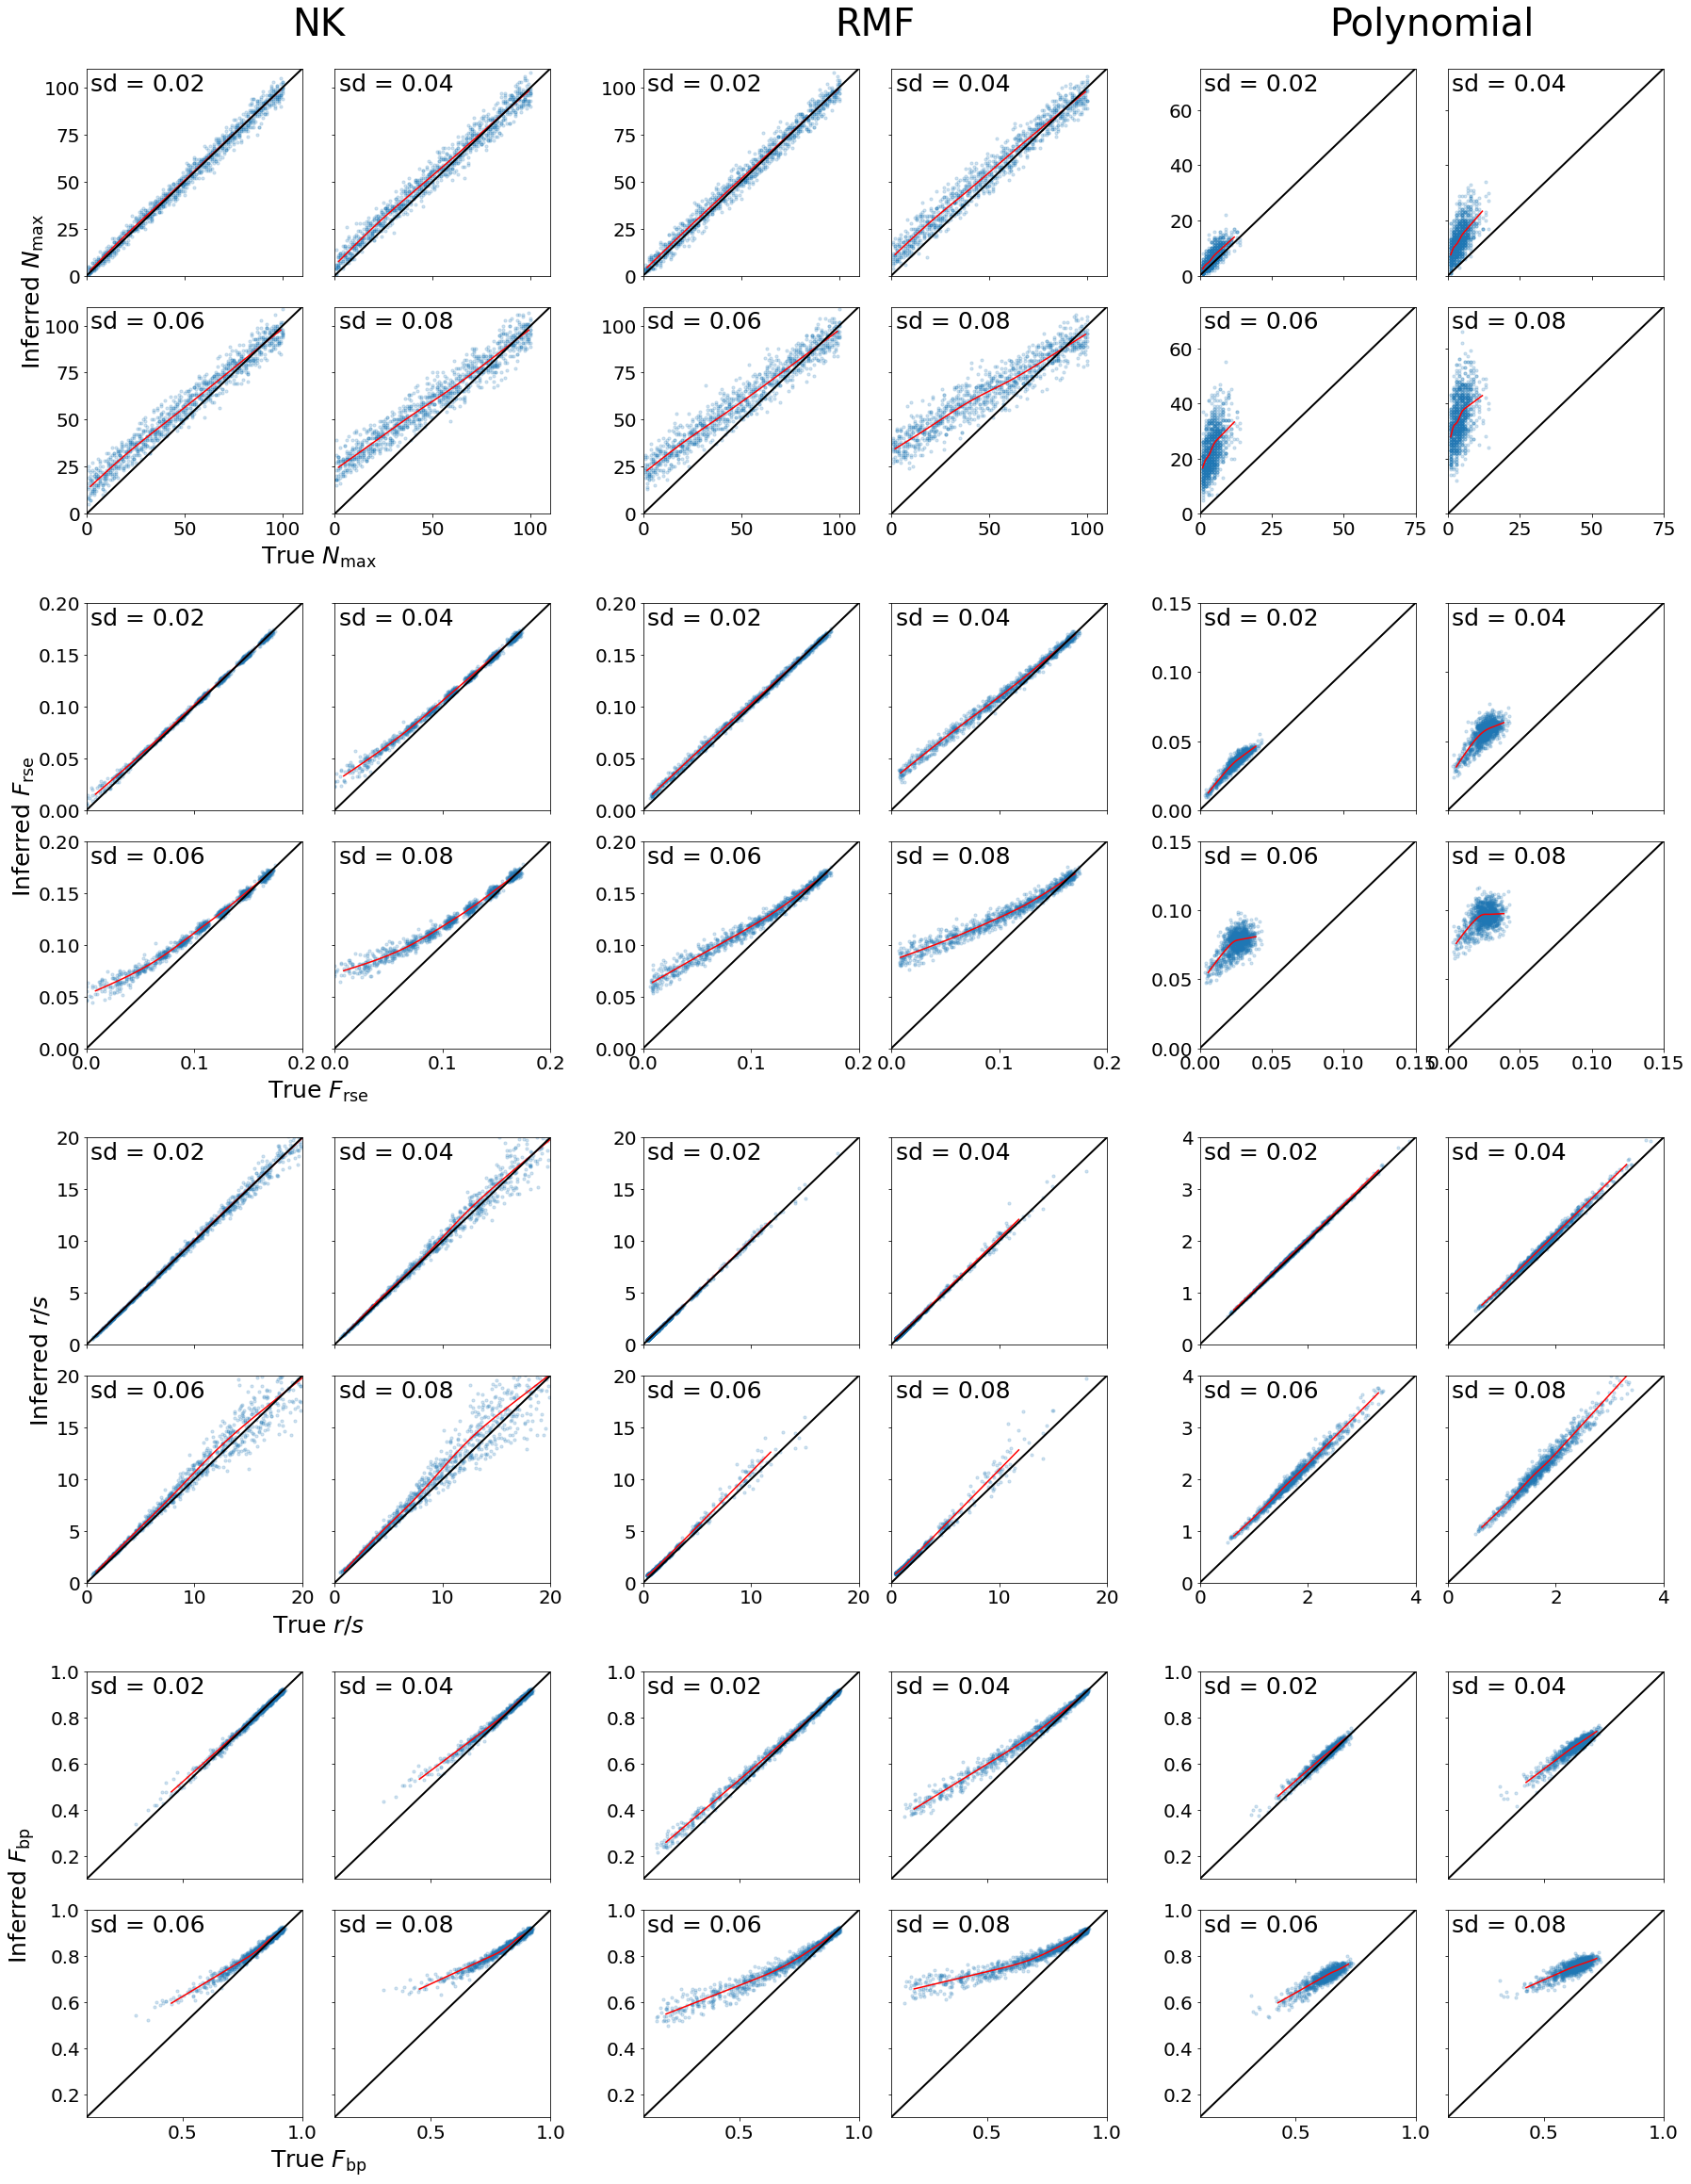

In [15]:
draw_N(10)

<ipython-input-14-b449dc9e2d0f>:86: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


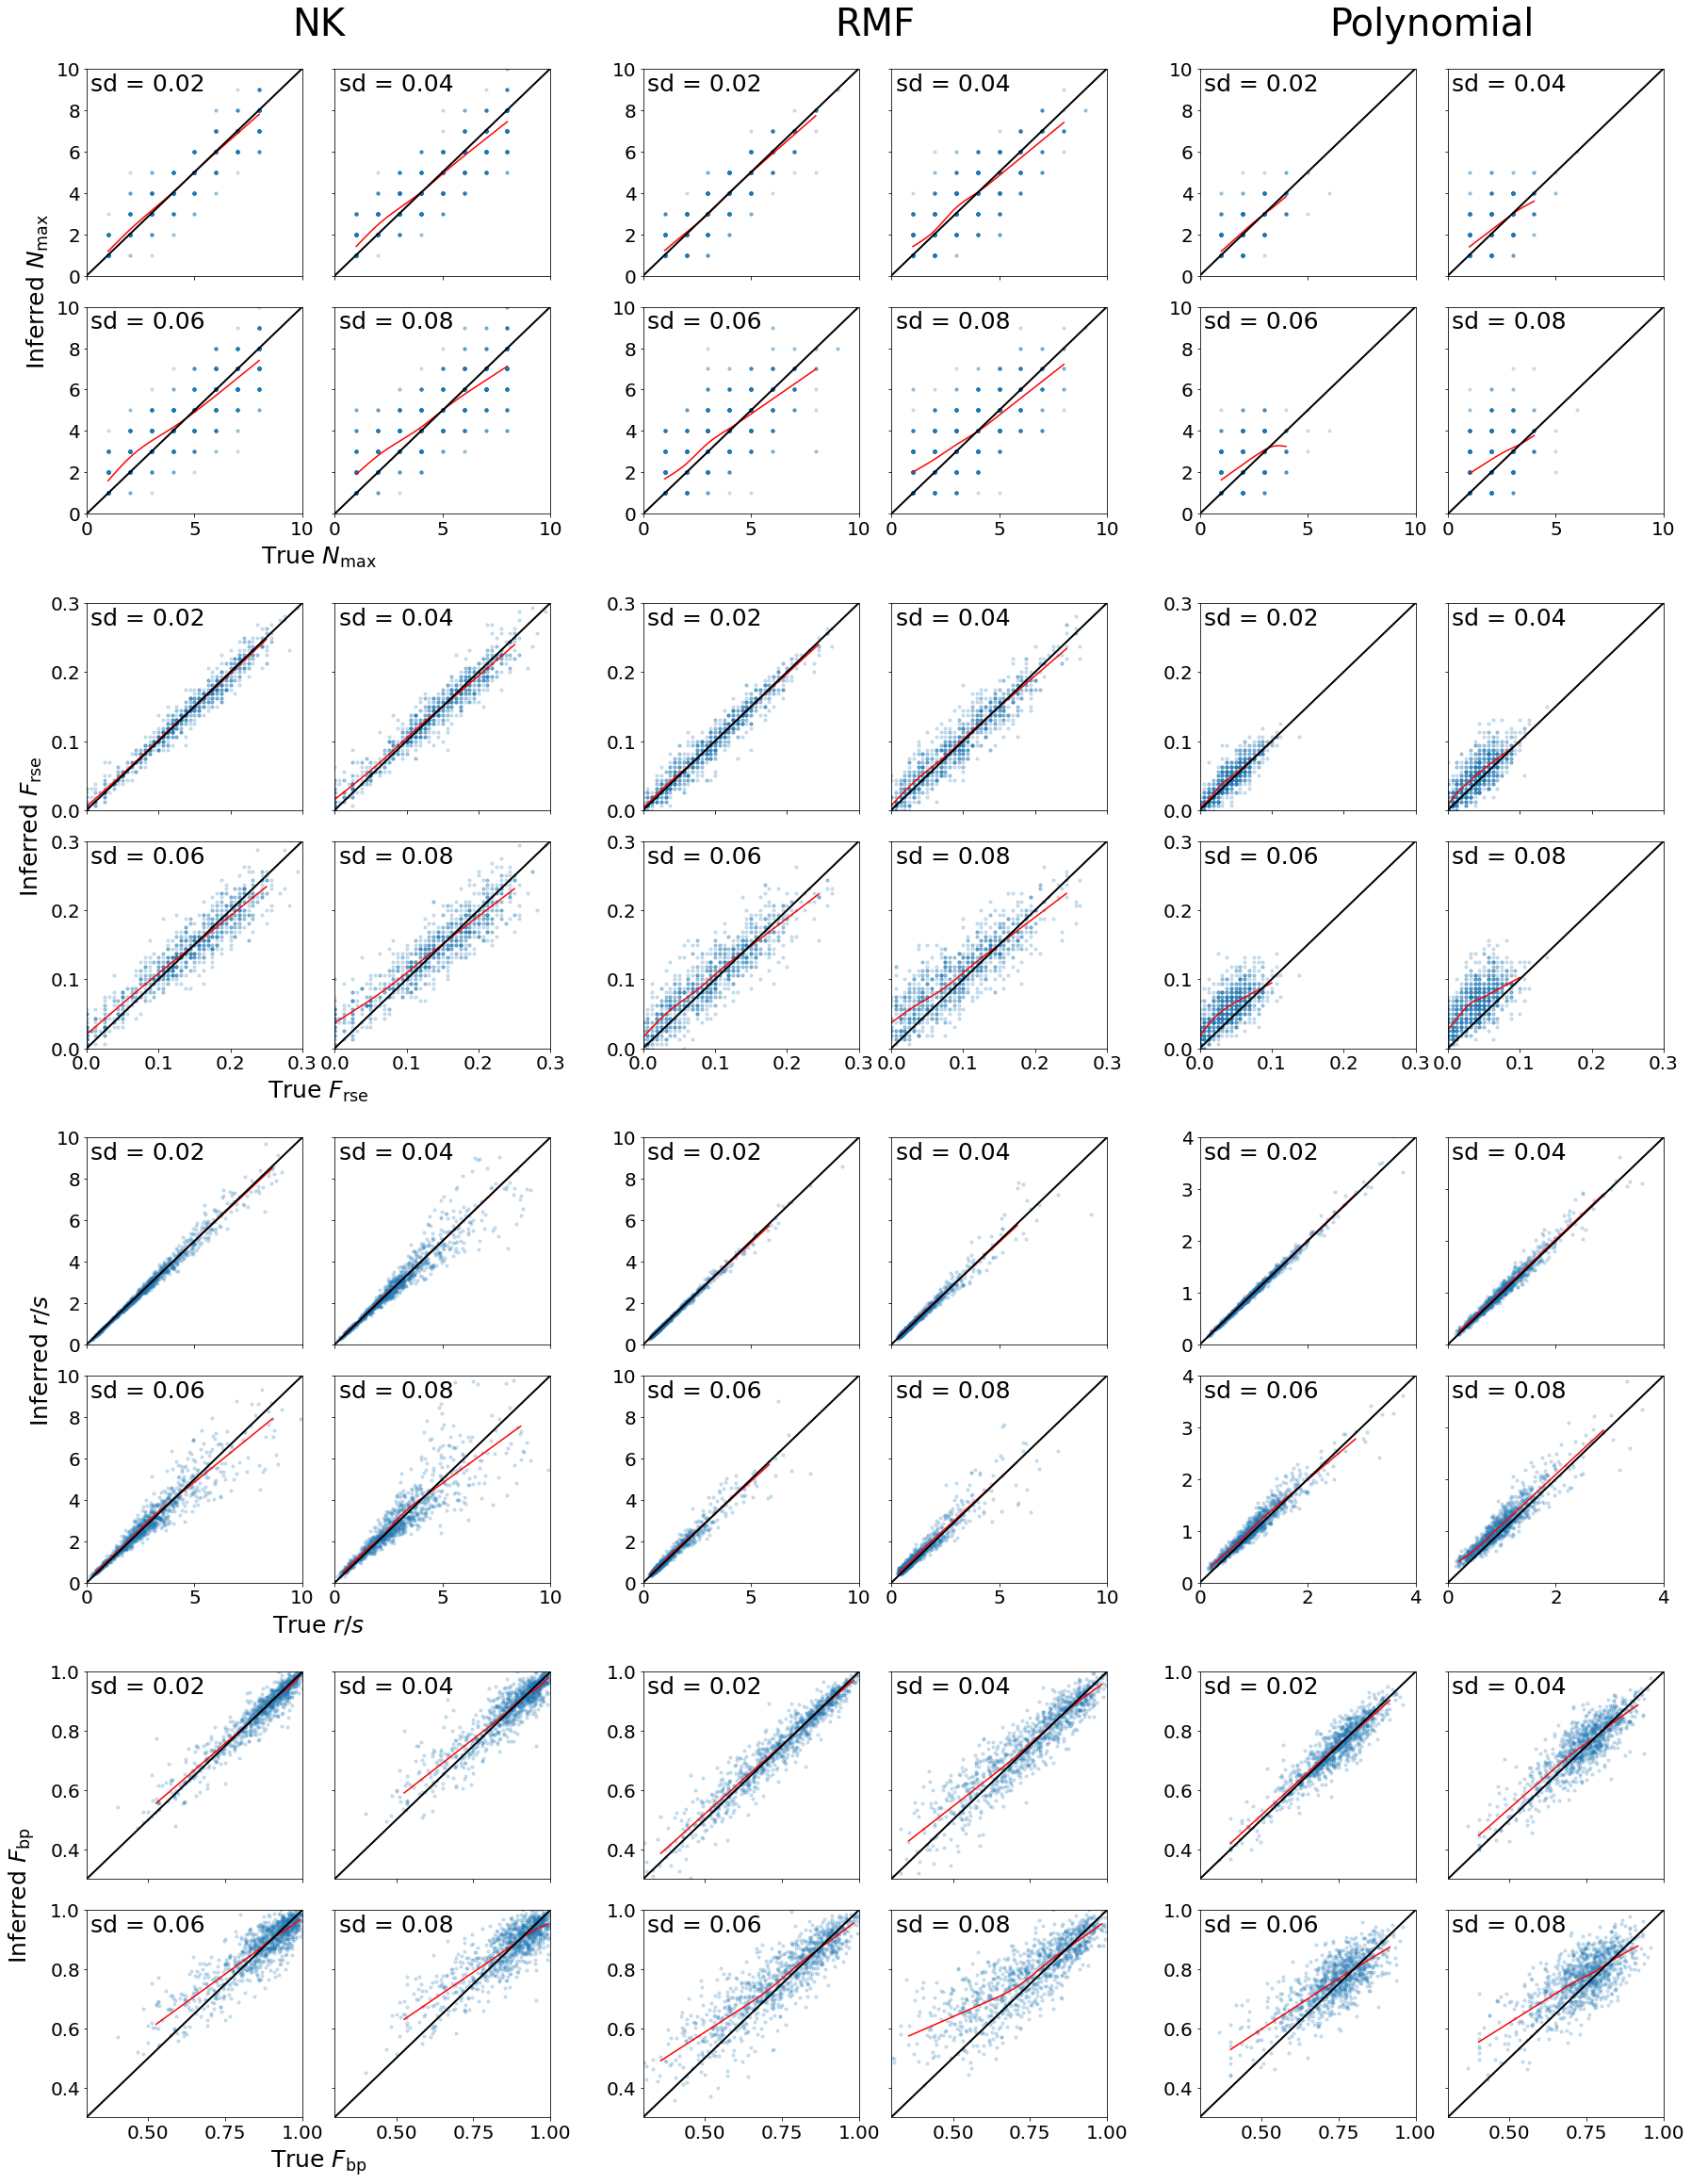

In [16]:
draw_N(5)

<ipython-input-14-b449dc9e2d0f>:86: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


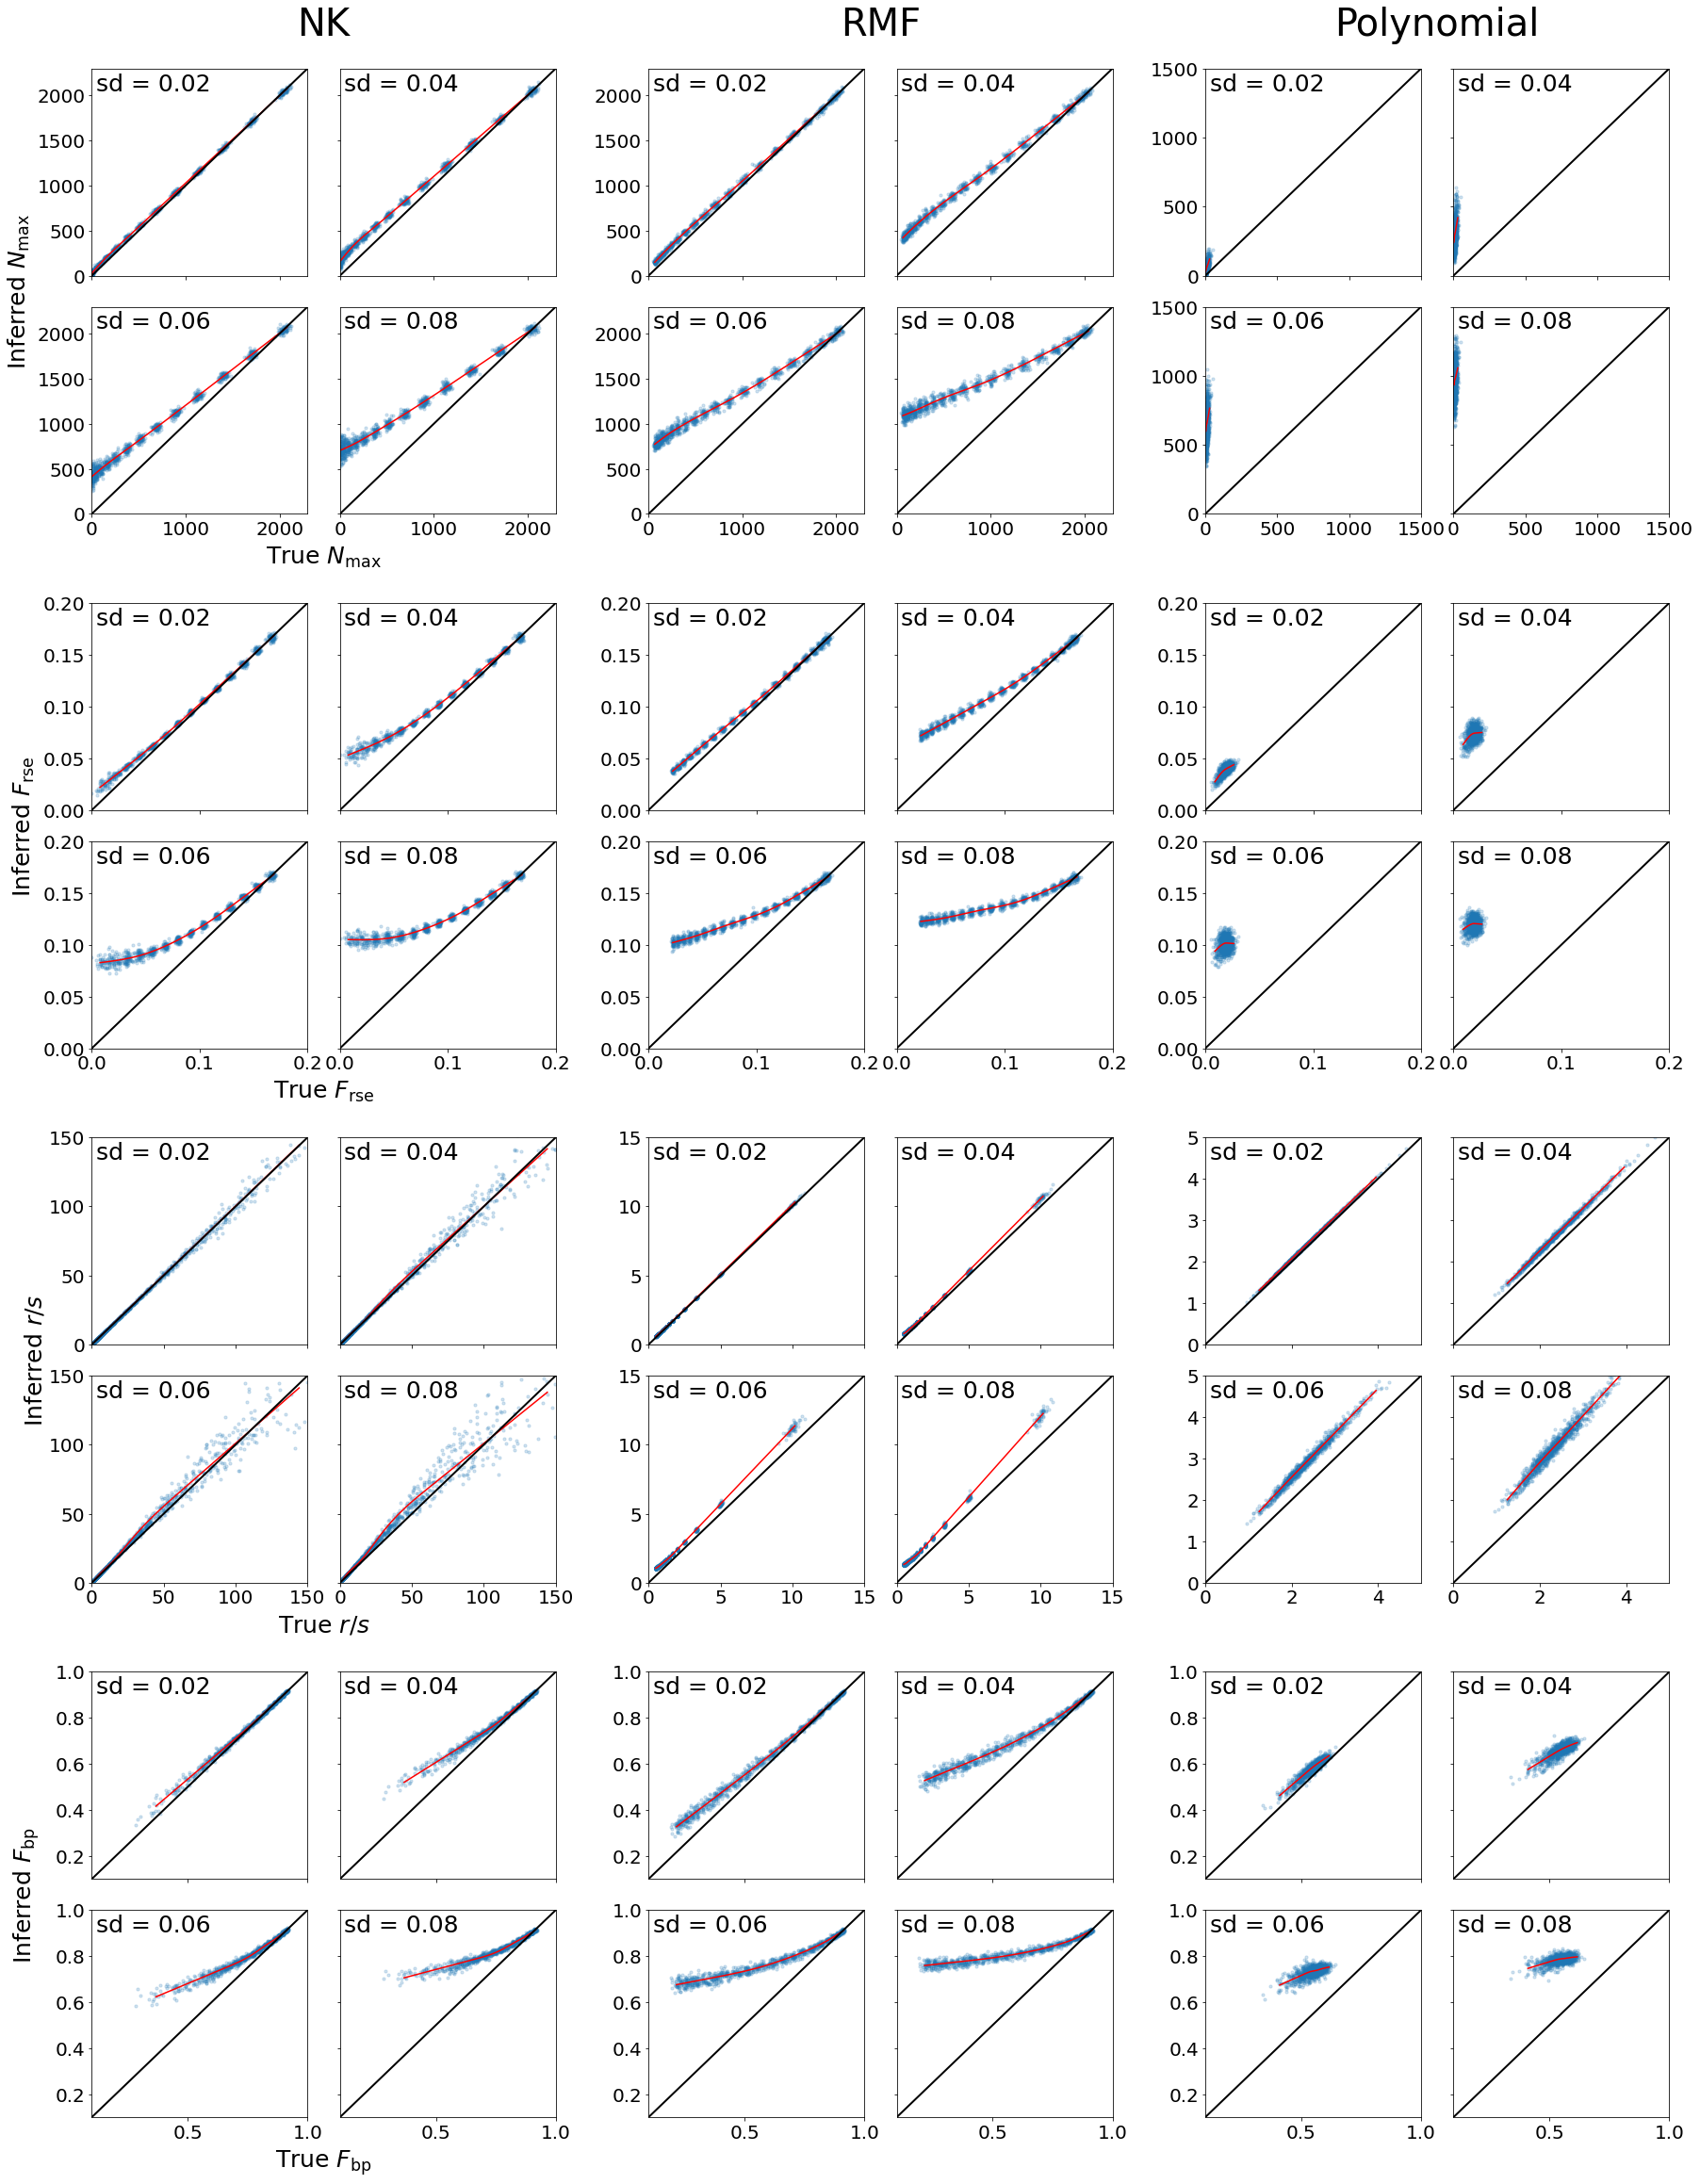

In [17]:
draw_N(15)

In [ ]:
'''
def draw_separate(metric):
"""
draw plots separately for each ruggedness measure
"""

    N = 10
    fig = plt.figure(figsize = [25,20])
    
    for ax_idx,model in enumerate(model_list):
        ax = fig.add_subplot(3,1,ax_idx+1)
        ax.spines['top'].set_color('none')
        ax.spines['bottom'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
        ax.set_ylabel(f'{model}',size=30,labelpad=70)

    for ax_idx,std in enumerate(error_list):
        ax = fig.add_subplot(1,4,ax_idx+1)
        ax.spines['top'].set_color('none')
        ax.spines['bottom'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
        ax.set_xlabel(f'std = {std}',size=30,labelpad=50)
    
    for row,model in enumerate(model_list):
        for column,std in enumerate(error_list):
            ax = fig.add_subplot(3,4,row*4+column+1)
            plot_df = plot_dict[N][model][metric]
            mean_df = get_mean_df(plot_df,N,model,metric)
            lim = para_dict[N][model][metric]['lim']

            ax.scatter(x=f'{metric}_T',y=f'{metric}_E',alpha=0.2, data=plot_df[plot_df['std']==std],label=None,s=10)
            mean_df_ = mean_df[mean_df['std']==std]
            ax.plot(mean_df_[f'{metric}_T'],mean_df_[f'{metric}_E_mean'],'r-',label=f'std {std}')
            ax.plot(lim,lim,'black',linewidth=2)
            if metric == 'open_ratio':
                ax.set_xticklabels(['0', '0.05', '0.1', '0.15'])
            ax.set_xlabel(f'std = {std}',fontsize=25)
            ax.set_ylabel(model, fontsize=25)
            ax.set_ylabel(f'{metric} (measured)',size=20,labelpad=para_dict[N][model][metric]['labelpad']-25)
            ax.set_xlabel(f'{metric} (ground true)',size=20,labelpad=8)
            ax.label_outer()
            ax.set_ylim(lim)
            ax.set_xlim(lim)
            ax.tick_params(labelsize=20)
            ax
    plt.subplots_adjust(
        wspace=0.1,
        hspace=0.1)
    #fig.tight_layout()
    fig.show()
'''

In [ ]:
# Stratified by metrics, Figs not shown in the paper
#draw_separate("N_max")

In [ ]:
# Stratified by metrics, Figs not shown in the paper
#draw_separate("epi")

In [ ]:
# Stratified by metrics, Figs not shown in the paper
#draw_separate("r_s")

In [ ]:
# Stratified by metrics, Figs not shown in the paper
#draw_separate("open_ratio")